In [1]:
import scanpy as sc
import squidpy as sq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# from bin import utils

In [2]:
# sc_data = sc.read_h5ad('./RNA/sc.combined.dedup.h5')
sc_data = sc.read_h5ad('/home/wpy/stereoseq/20240702-Exclusive/RNA/sc.reclustered.h5')

In [14]:
# Save matrix with gene names as header
np.savetxt('./RNA/sc.reclustered.matrix.txt', 
           sc_data.X.toarray(),
           delimiter='\t',
           header='\t'.join(sc_data.var_names),
           comments='')
sc_data.obs.to_csv('/home/wpy/stereoseq/20240702-Exclusive/RNA/sc.reclustered.obs.csv')

TypeError: savetxt() got an unexpected keyword argument 'index'

In [3]:
spatial_data = sc.read_h5ad('/home/wpy/stereoseq/20240702-Exclusive/RNA/spatial.combined.bin20.h5')
guide_data = spatial_data[:, spatial_data.var_names.str.startswith('sg')].copy()
expr_data = spatial_data[guide_data.X.toarray().sum(axis=1) > 0, ~spatial_data.var_names.str.startswith('sg')].copy()

bin100_data = sc.read_h5ad('/home/wpy/stereoseq/20240702-Exclusive/RNA/reclustered.h5')
bin100_data.obs['coord_x'] = bin100_data.obsm['spatial'][:, 0] // 100 * 100
bin100_data.obs['coord_y'] = bin100_data.obsm['spatial'][:, 1] // 100 * 100

expr_data.obs['bin100_x'] = expr_data.obsm['spatial'][:, 0] // 100 * 100
expr_data.obs['bin100_y'] = expr_data.obsm['spatial'][:, 1] // 100 * 100

# 获取bin100_data中的坐标对
bin100_coords = set(zip(bin100_data.obs.marker, bin100_data.obs['coord_x'], bin100_data.obs['coord_y']))

# 过滤expr_data,只保留坐标对在bin100_coords中的数据
mask = [(m,x,y) in bin100_coords for m,x,y in zip(expr_data.obs.marker, expr_data.obs['bin100_x'], expr_data.obs['bin100_y'])]
expr_data = expr_data[mask].copy()

expr_data

AnnData object with n_obs × n_vars = 3112 × 20857
    obs: 'marker', 'bin100_x', 'bin100_y'
    obsm: 'spatial'

In [6]:
np.savetxt('/home/wpy/stereoseq/20240702-Exclusive/RNA/spatial.reclustered.matrix.txt',
           expr_data.X.toarray(),
           delimiter='\t',
           header='\t'.join(expr_data.var_names),
           comments='')
expr_data.obs.to_csv('/home/wpy/stereoseq/20240702-Exclusive/RNA/spatial.reclustered.obs.csv')
np.savetxt('/home/wpy/stereoseq/20240702-Exclusive/RNA/spatial.reclustered.spatial.txt',
           expr_data.obsm['spatial'],
           delimiter='\t')

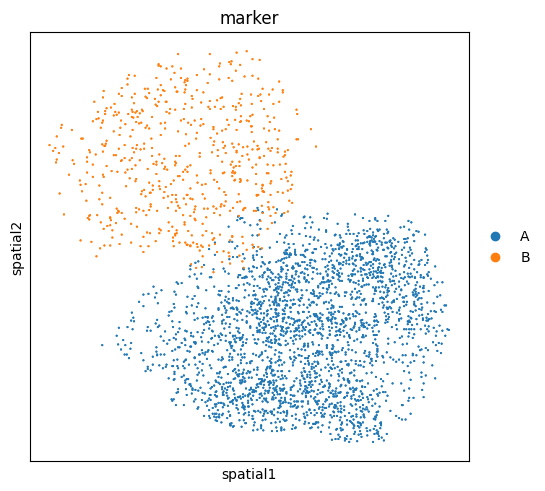

In [10]:
sq.pl.spatial_scatter(expr_data, color='marker', size=1, library_id='spatial', shape=None, alpha=1)

In [4]:
from bin import utils
guide_data = utils.combine_guide_replicates(guide_data)

/home/wpy/stereoseq/20240702-Exclusive/bin/utils.py:78: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  sgs_grouped = sgs_grouped.groupby(sgs, axis=1).sum()


# Single cell check

In [5]:
import anndata as ad

def combine_guide_replicates(gdata):
    """
    Usage:
        combine guide replicates in <gdata> to a single gene name
    Return:
        single gene name anndata
    """
    sgs = gdata.var_names.str.split('_', n=1).str[0]
    sgs_grouped = pd.DataFrame(gdata.X.toarray(), columns=gdata.var_names)
    sgs_grouped = sgs_grouped.groupby(sgs, axis=1).sum()

    cgdata = ad.AnnData(sgs_grouped, obs=gdata.obs, var=pd.DataFrame(index=sgs_grouped.columns))
    cgdata.obsm['spatial'] = gdata.obsm['spatial']
    return cgdata

guide_data = combine_guide_replicates(guide_data)

/tmp/ipykernel_293893/2505534721.py:12: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  sgs_grouped = sgs_grouped.groupby(sgs, axis=1).sum()


In [6]:
# Bin 20
from scipy.stats import spearmanr
from tqdm import tqdm
r = {}
for guide in tqdm(sc_data.obs.perturb_gene.unique()):
    if guide != "Duplicate" and guide in guide_data.var_names:
        spatial_vec = spatial_data[guide_data[:, guide].X.toarray() > 0, ~spatial_data.var_names.str.startswith('sg')]
        sc_vec = sc_data[sc_data.obs.perturb_gene == guide, :]

        common_genes = np.intersect1d(spatial_vec.var_names.tolist(), sc_vec.var_names.tolist())
        spatial_df = pd.DataFrame(spatial_vec.X.toarray().sum(axis=0), index=spatial_vec.var_names.tolist(), columns=['spatial']).loc[common_genes, :]
        sc_df = pd.DataFrame(sc_vec.X.toarray().sum(axis=0), index=sc_vec.var_names.tolist(), columns=['sc']).loc[common_genes, :]
        
        cdf = pd.concat([spatial_df, sc_df], axis=1)
        r[guide] = spearmanr(cdf.spatial, cdf.sc)[0]
rdf = pd.DataFrame(r, index=['spearmanr'])

100%|██████████| 34/34 [00:01<00:00, 18.60it/s]


In [7]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# 初始化一个字典来存储每个基因的累计排名差异
gene_rank_diff = {}

# 遍历每个 guide
for guide in tqdm(sc_data.obs.perturb_gene.unique()):
    if guide != "Duplicate" and guide in guide_data.var_names:
        # 提取对应 guide 的 spatial 和 sc 数据
        spatial_vec = spatial_data[guide_data[:, guide].X.toarray() > 0, ~spatial_data.var_names.str.startswith('sg')]
        sc_vec = sc_data[sc_data.obs.perturb_gene == guide, :]

        # 找到共同基因
        common_genes = np.intersect1d(spatial_vec.var_names.tolist(), sc_vec.var_names.tolist())
        
        # 提取空间数据和单细胞数据，并保留共同基因
        spatial_df = pd.DataFrame(spatial_vec.X.toarray().sum(axis=0), index=spatial_vec.var_names.tolist(), columns=['spatial']).loc[common_genes, :]
        sc_df = pd.DataFrame(sc_vec.X.toarray().sum(axis=0), index=sc_vec.var_names.tolist(), columns=['sc']).loc[common_genes, :]
        
        # 计算 spatial 和 sc 中基因表达量的排名
        spatial_ranks = spatial_df['spatial'].rank(ascending=False)  # 降序排名
        sc_ranks = sc_df['sc'].rank(ascending=False)  # 降序排名
        
        # 计算每个基因的排名差异（绝对值差异）
        rank_diff = (spatial_ranks - sc_ranks).abs()

        # 将每个基因的排名差异累计到 gene_rank_diff 字典中
        for gene in common_genes:
            if gene not in gene_rank_diff:
                gene_rank_diff[gene] = []
            gene_rank_diff[gene].append(rank_diff[gene])

# 计算每个基因在所有 guide 中的平均排名差异
avg_rank_diff = {gene: np.mean(diffs) for gene, diffs in gene_rank_diff.items()}

# 转换为 DataFrame 并按平均差异排序
avg_rank_diff_df = pd.DataFrame.from_dict(avg_rank_diff, orient='index', columns=['avg_rank_diff'])
avg_rank_diff_df = avg_rank_diff_df.sort_values(by='avg_rank_diff', ascending=True)

100%|██████████| 34/34 [00:02<00:00, 13.32it/s]


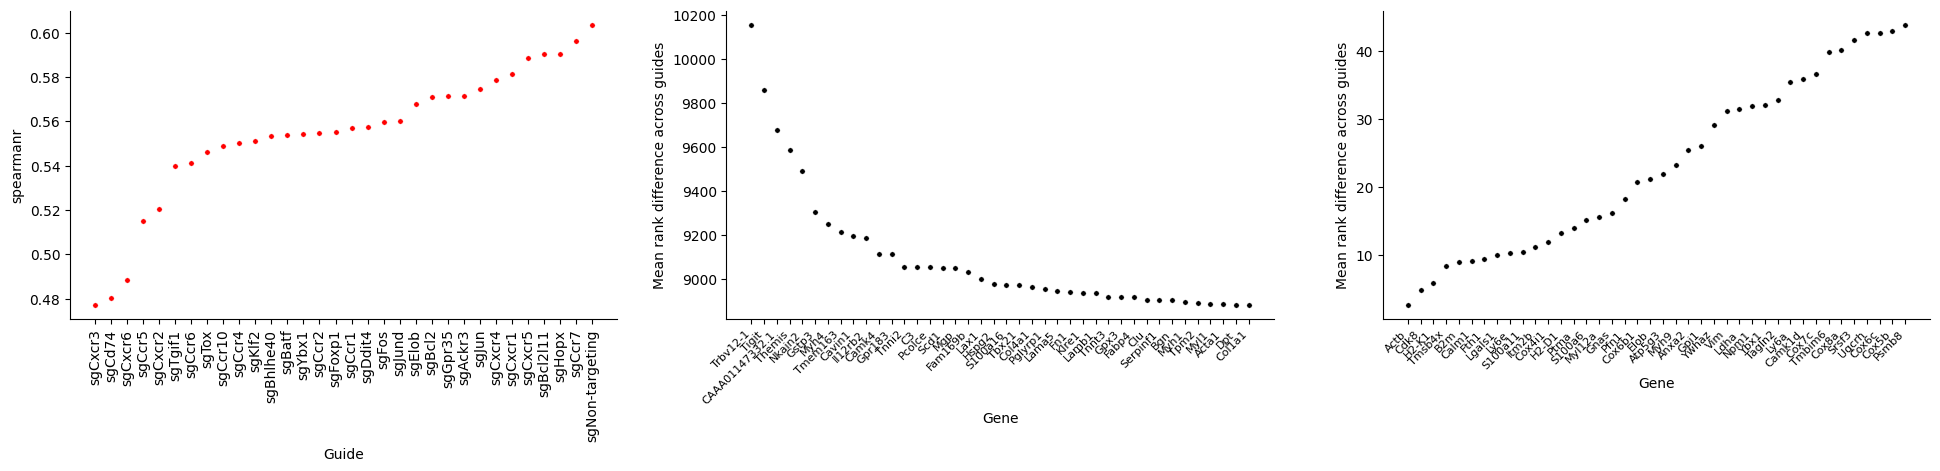

In [8]:
rdf = pd.DataFrame(r, index=['spearmanr']).T.sort_values(by='spearmanr')
_, ax = plt.subplots(1, 3, figsize=(24, 4))
sns.scatterplot(avg_rank_diff_df.head(40).reset_index(), x='index', y='avg_rank_diff', c='black', s=15, ax=ax[2])
sns.scatterplot(avg_rank_diff_df.sort_values(by='avg_rank_diff', ascending=False).head(40).reset_index(), x='index', y='avg_rank_diff', c='black', s=15, ax=ax[1])
sns.scatterplot(rdf, x=rdf.index, y=rdf.spearmanr, ax=ax[0], c='red', s=15)
sns.despine()

ax[2].set_xlabel('Gene')
ax[2].set_ylabel('Mean rank difference across guides')
ax[1].set_xlabel('Gene')
ax[1].set_ylabel('Mean rank difference across guides')
ax[0].set_xlabel('Guide')

ax[2].set_xticks(list(range(40)), avg_rank_diff_df.head(40).index, rotation=45, ha='right', size=8)
ax[1].set_xticks(list(range(40)), avg_rank_diff_df.sort_values(by='avg_rank_diff', ascending=False).head(40).index, rotation=45, ha='right', size=8)
ax[0].set_xticks(list(range(len(rdf.index))), rdf.index, rotation=90)
plt.show()

# Check

In [5]:
guide_data = guide_data[guide_data.obs['marker'] == 'A'].copy()
spatial_df = pd.DataFrame(guide_data.X, columns=guide_data.var_names.tolist(), index=guide_data.obs_names.tolist())
# spatial_df['coord_x'] = guide_data.obsm['spatial'][:, 0]
# spatial_df['coord_y'] = guide_data.obsm['spatial'][:, 1]
spatial_df = spatial_df[~(spatial_df.sum(axis=1) == 0)]
var_map = pd.DataFrame(guide_data.var_names).to_dict()[0]
spatial_df['guide'] = spatial_df.max(axis=1).map(var_map)
spatial_df = spatial_df.iloc[:, -3:]
spatial_df = spatial_df[spatial_df['guide'] != 'None']
spatial_df

sgTox  sgYbx1      guide
69528       0       0     sgBatf
241262      0       0  sgBcl2l11
72929       0       0     sgBatf
168645      0       0     sgCcr1
166961      0       1     sgBatf
...       ...     ...        ...
198852      0       0     sgBatf
100861      0       0     sgBatf
90697       0       0     sgBcl2
86768       0       0     sgBatf
108175      0       0     sgBatf

[2852 rows x 3 columns]

In [6]:
map_df = pd.read_csv('/home/wpy/stereoseq/20240702-Exclusive/RNA/sc.double.t_map.csv', sep='\t', header=0, index_col=0)
map_df.index = map_df.index.str.split('.').str[:2].str.join('-')
map_df

coord_x      coord_y            perturb  \
ACGGAGAAGTGCGATG-1  8533.456239  5906.861734  sgNon-targeting_1   
TTAGTTCGTGTTTGTG-1  8623.538537  5911.082050          Duplicate   
TTTATGCTCGAGAGCA-1  8542.763626  5997.299825          Duplicate   
CACCACTTCGTCACGG-1  8570.216618  5892.431196          Duplicate   
TACTCATAGTGTACCT-1  8571.706082  5970.789944          Duplicate   
...                         ...          ...                ...   
TCATTTGCAAGTCATC-1  3265.934611  8363.861561          Duplicate   
CACATAGAGTAGCGGT-1  3275.542190  8248.272327          Duplicate   
GAGCAGATCGTTTATC-1  3226.244291  8358.893818            sgFos_1   
GATCGTAAGAGTAATC-1  3269.671095  8287.839109           sgKlf2_2   
GCCTCTACACTTAAGC-1  3251.444304  8326.494492          Duplicate   

                       perturb_gene phenotype  
ACGGAGAAGTGCGATG-1  sgNon-targeting      Teff  
TTAGTTCGTGTTTGTG-1        Duplicate       Tex  
TTTATGCTCGAGAGCA-1        Duplicate       Tex  
CACCACTTCGTCACGG-1        Duplicate       Tex  
TACTCATAGTGTACCT-1        Duplicate      Teff  
...                             ...       ...  
TCATTTGCAAGTCATC-1        Duplicate      Tpex  
CACATAGAGTAGCGGT-1        Duplicate      Tpex  
GAGCAGATCGTTTATC-1            sgFos      Tpex  
GATCGTAAGAGTAATC-1           sgKlf2       Tem  
GCCTCTACACTTAAGC-1        Duplicate       Tem  

[12382 rows x 5 columns]

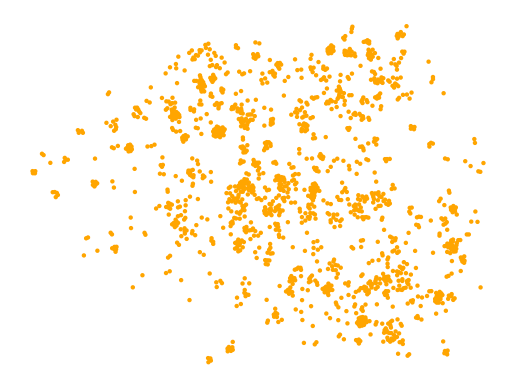

In [18]:
sns.scatterplot(map_df[map_df.phenotype == 'Trm'], x='coord_x', y='coord_y', color='orange', s=10, edgecolor='none')
# sns.scatterplot(map_df[map_df.perturb_gene == 'sgBhlhe40'], x='coord_x', y='coord_y', s=5, color='tomato', alpha=0.5)
# sns.scatterplot(map_df[map_df.perturb_gene == 'sgNon-targeting'], x='coord_x', y='coord_y', s=5, color='gray', alpha=0.5)
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
sns.despine(left=True, bottom=True)
plt.show()

In [20]:
adata = bin100_data[bin100_data.obs['marker'] == 'A'].copy()
adata.obs['coord_x_100'] = (adata.obsm['spatial'][:, 0] + 50) // 100 * 100
adata.obs['coord_y_100'] = (adata.obsm['spatial'][:, 1] + 50) // 100 * 100
st_df = adata.obs

In [26]:
# st_df.set_index(['coord_x_100', 'coord_y_100'], inplace=True)
map_df.set_index(['coord_x_100', 'coord_y_100'], inplace=True)

In [32]:
map_df['cluster'] = map_df.index.map(st_df['cluster'].to_dict())

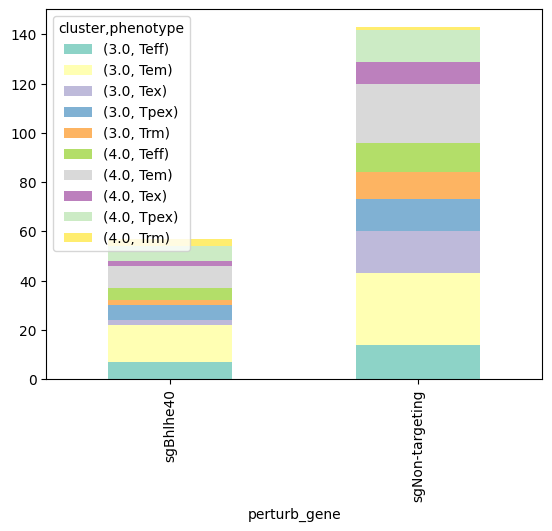

In [71]:
pdf = map_df.groupby('cluster')[['phenotype', 'perturb_gene']].value_counts().unstack()[['sgBhlhe40', 'sgNon-targeting']].loc[[3, 4], :]
pdf.reset_index(inplace=True)
pdf.set_index(['cluster', 'phenotype'], inplace=True)
pdf.T.plot.bar(stacked=True, cmap='Set3')

plt.rcParams['pdf.fonttype'] = 42
plt.savefig('./plots/map_cluster_guide_count.pdf')
plt.show()

In [25]:
map_df['coord_x_100'] = ((map_df['coord_x'] + 50) // 100 * 100).astype(int)
map_df['coord_y_100'] = ((map_df['coord_y'] + 50) // 100 * 100).astype(int)
map_df

coord_x      coord_y            perturb  \
coord_x_100 coord_y_100                                                
8500.0      5900.0       8533.456239  5906.861734  sgNon-targeting_1   
8600.0      5900.0       8623.538537  5911.082050          Duplicate   
8500.0      6000.0       8542.763626  5997.299825          Duplicate   
8600.0      5900.0       8570.216618  5892.431196          Duplicate   
            6000.0       8571.706082  5970.789944          Duplicate   
...                              ...          ...                ...   
3300.0      8400.0       3265.934611  8363.861561          Duplicate   
            8200.0       3275.542190  8248.272327          Duplicate   
3200.0      8400.0       3226.244291  8358.893818            sgFos_1   
3300.0      8300.0       3269.671095  8287.839109           sgKlf2_2   
            8300.0       3251.444304  8326.494492          Duplicate   

                            perturb_gene phenotype  coord_x_100  coord_y_100  
coord_x_100 coord_y_100                                                       
8500.0      5900.0       sgNon-targeting      Teff         8500         5900  
8600.0      5900.0             Duplicate       Tex         8600         5900  
8500.0      6000.0             Duplicate       Tex         8500         6000  
8600.0      5900.0             Duplicate       Tex         8600         5900  
            6000.0             Duplicate      Teff         8600         6000  
...                                  ...       ...          ...          ...  
3300.0      8400.0             Duplicate      Tpex         3300         8400  
            8200.0             Duplicate      Tpex         3300         8200  
3200.0      8400.0                 sgFos      Tpex         3200         8400  
3300.0      8300.0                sgKlf2       Tem         3300         8300  
            8300.0             Duplicate       Tem         3300         8300  

[12382 rows x 7 columns]

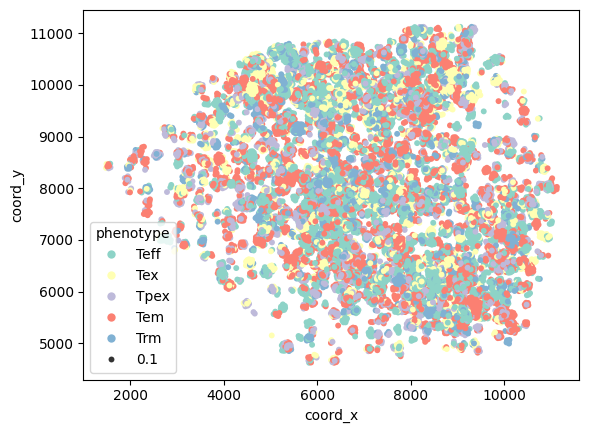

In [55]:
sns.scatterplot(map_df, x='coord_x', y='coord_y', hue='phenotype', size=0.1, legend=True, palette='Set3', edgecolor='none')
plt.show()

In [12]:
bin100_data.obs

marker  n_counts  n_genes      x     y  _scvi_batch  _scvi_labels  \
11351       A      7608     1965  10049  5049            0             0   
10460       A     20297     4257   9249  6349            0             0   
6061        A     18797     3904   5349  7149            0             0   
7424        A     23617     4561   6549  7849            0             0   
7653        A     21658     4403   6748  8149            0             0   
...       ...       ...      ...    ...   ...          ...           ...   
5804        B        11        9   5849   349            1             0   
6210-1      B        15       10   6249   949            1             0   
2808        B        44       19   2849   748            1             0   
135         B        35       17    149  3449            1             0   
3864-1      B         6        4   3849  6350            1             0   

       cluster  coord_x  coord_y  
11351        0    10000     5000  
10460        4     9200     6300  
6061         0     5300     7100  
7424         6     6500     7800  
7653         6     6700     8100  
...        ...      ...      ...  
5804         4     5800      300  
6210-1       4     6200      900  
2808         4     2800      700  
135          4      100     3400  
3864-1       4     3800     6300  

[8441 rows x 10 columns]

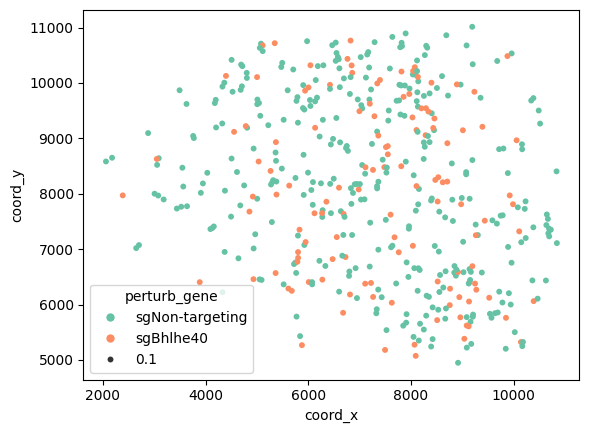

In [59]:
sns.scatterplot(map_df[map_df.perturb_gene.isin(['sgBhlhe40', 'sgNon-targeting'])], x='coord_x', y='coord_y', hue='perturb_gene', size=0.1, legend=True, palette='Set2', edgecolor='none')
plt.show()

In [9]:
cluster_data = sc.read_h5ad('./RNA/spatial.combined.clustered.h5')
cluster_data = cluster_data[cluster_data.obs['marker'] == 'A']

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/squidpy/pl/_color_utils.py:25: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  target.uns[color_key] = source.uns[color_key]
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


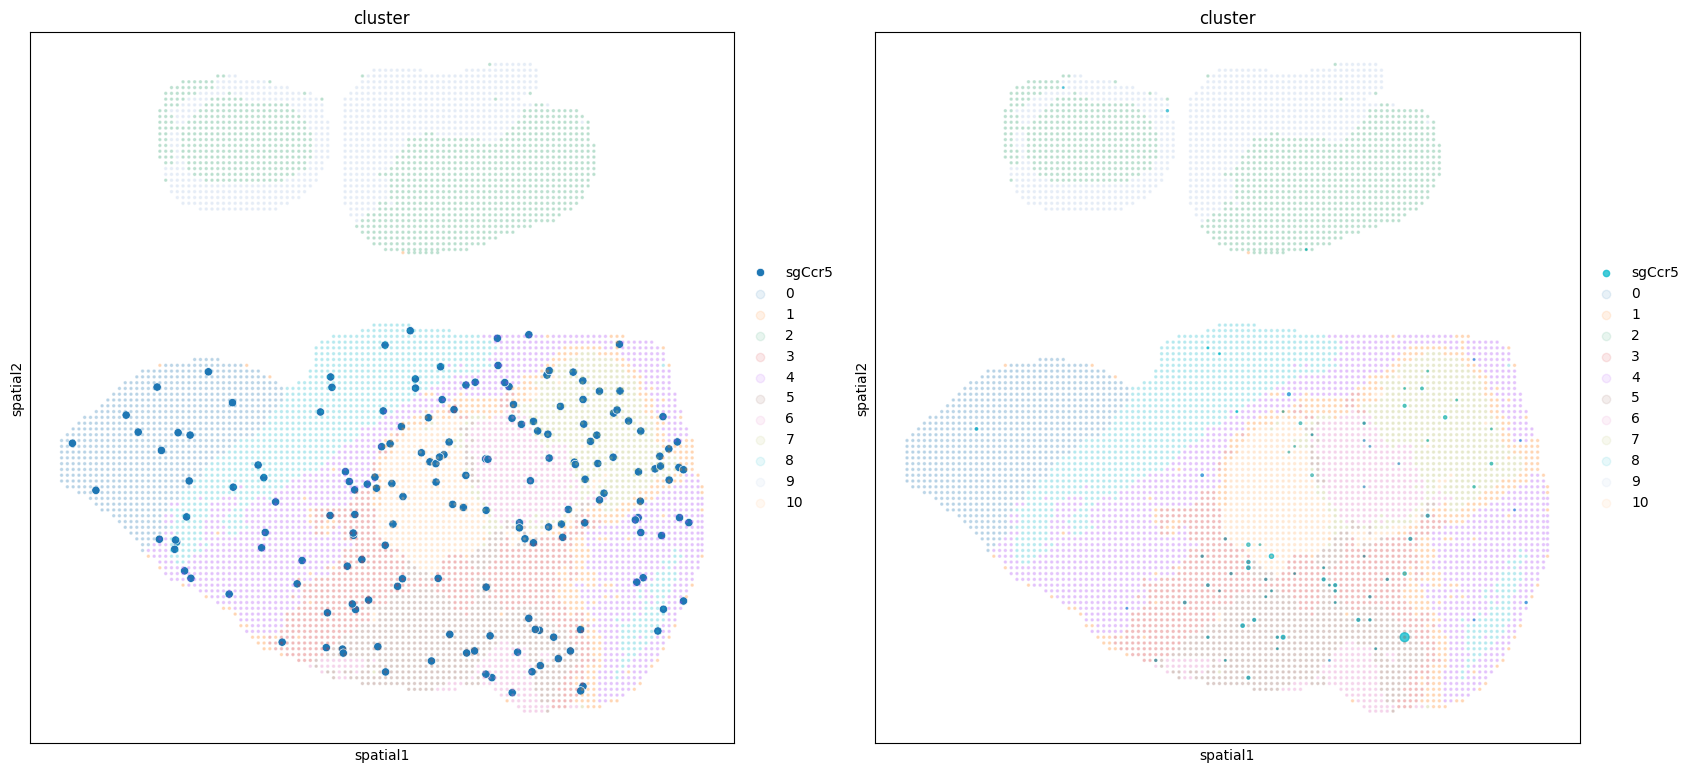

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(20, 12))
sns.scatterplot(map_df[map_df.perturb_gene == 'sgCcr5'], x='coord_x', y='coord_y', hue='perturb_gene', legend=True, ax=ax[0])
# sns.scatterplot(spatial_df, x='coord_x', y='coord_y', hue='guide', size=0.001, legend=True, ax=ax[1])
colors = sns.color_palette("tab10", len(guide_data.var_names.unique()))
color_mapping = {guide: color for guide, color in zip(guide_data.var_names.unique(), colors)}
for guide in guide_data.var_names.unique():
    if guide not in ['sgCcr5']: continue
    utils.plot_dot(guide_data, gene_name=guide, ax=ax[1], square=False, alpha=0.8, color=color_mapping[guide])
sq.pl.spatial_scatter(cluster_data, color='cluster', shape=None, size=10, library_id='spatial', alpha=0.1, ax=ax[0])
sq.pl.spatial_scatter(cluster_data, color='cluster', shape=None, size=10, library_id='spatial', alpha=0.1, ax=ax[1])
plt.show()

In [97]:
map_df['perturb_gene'].map(lambda x: color_mapping[x] if x not in ['Duplicate', 'sgTcf7'] else 'white')

GCTGCTTGTTTAAGCC.1          (1.0, 0.4980392156862745, 0.054901960784313725)
AAGGTTCTCGCTTAGA.1        (0.09019607843137255, 0.7450980392156863, 0.81...
CAGCCGATCCCGACTT.1        (0.8392156862745098, 0.15294117647058825, 0.15...
CGGAGCTAGGCTACGA.1          (1.0, 0.4980392156862745, 0.054901960784313725)
TCACAAGCAATGACCT.1                                                    white
                                                ...                        
TCAACGAGTGCCTTGG.1.4        (1.0, 0.4980392156862745, 0.054901960784313725)
TGCGCAGTCTCGAGTA.1.4        (1.0, 0.4980392156862745, 0.054901960784313725)
TGGGAAGTCGAACGGA.1.3                                                  white
GTGCTTCCAAACTGCT.1.4      (0.7372549019607844, 0.7411764705882353, 0.133...
CAAGGCCGTAGCCTAT.1.1.1    (0.8392156862745098, 0.15294117647058825, 0.15...
Name: perturb_gene, Length: 11270, dtype: object

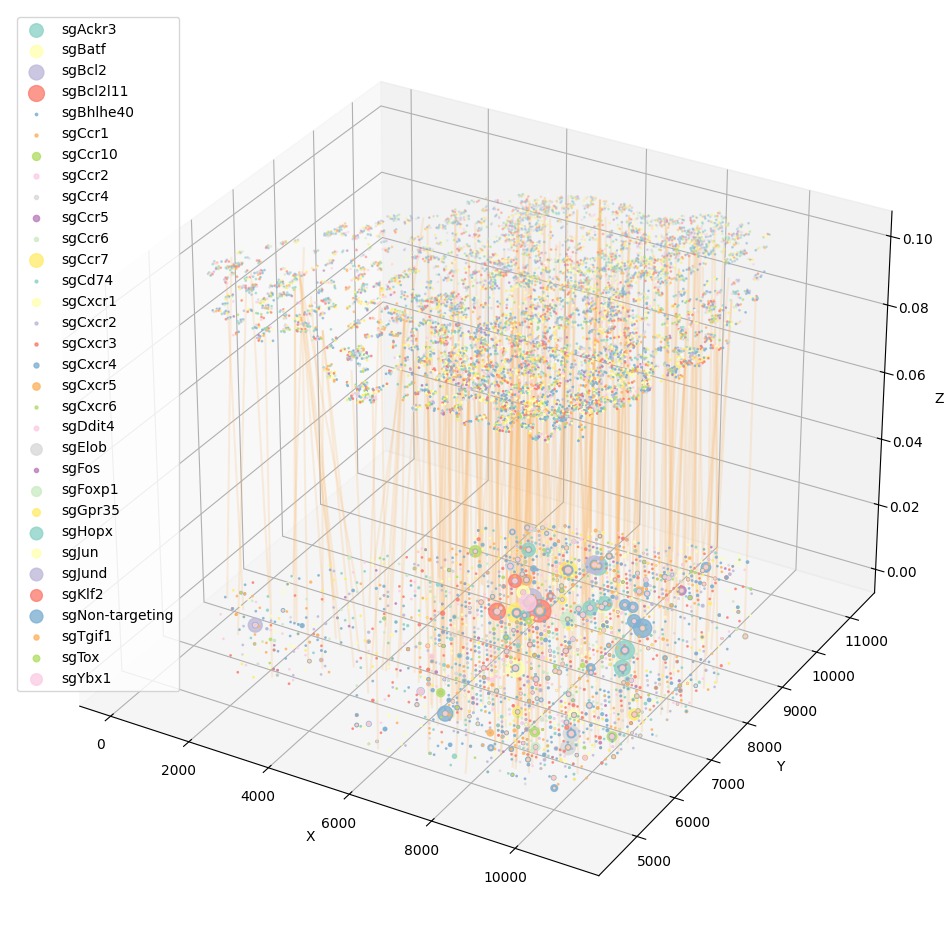

In [14]:
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import KDTree

# 创建颜色映射
unique_guides = guide_data.var_names.unique()
colors = sns.color_palette("Set3", len(unique_guides))
color_mapping = {guide: color for guide, color in zip(unique_guides, colors)}

# 3D 绘图
fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(111, projection='3d')

# 绘制 map_df 和 guide_data 在 3D 空间中
map_df = map_df[~(map_df['perturb_gene'] == 'Duplicate')]
ax.scatter(map_df['coord_x'], map_df['coord_y'], np.zeros_like(map_df['coord_x']) + 0.1, s=1, c=map_df['perturb_gene'].map(lambda x: color_mapping[x] if x not in ['sgTcf7'] else 'white'))
for guide in unique_guides:
    utils.plot_dot(guide_data[guide_data.obsm['spatial'][:, 1] > 4000], gene_name=guide, ax=ax, square=False, alpha=0.8, color=color_mapping[guide])

# 添加虚线连接 guide 相同的、最近的点
for guide in unique_guides:
    
    if guide not in ['sgCxcr5']: continue
    map_df_guide = map_df[map_df['perturb_gene'] == guide]
    guide_data_guide = pd.DataFrame(guide_data[guide_data[:, guide].X > 0].obsm['spatial'], columns=['coord_x', 'coord_y'])

    # 使用 KDTree 找到最近的点
    tree = KDTree(guide_data_guide[['coord_x', 'coord_y']])
    distances, indices = tree.query(map_df_guide[['coord_x', 'coord_y']], k=1)
    
    for i, idx in enumerate(indices):
        x1, y1 = map_df_guide.iloc[i][['coord_x', 'coord_y']]
        x2, y2 = guide_data_guide.iloc[idx][['coord_x', 'coord_y']]
        ax.plot([x1, x2], [y1, y2], [0, 0.1], color=color_mapping[guide], alpha=0.2)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show()

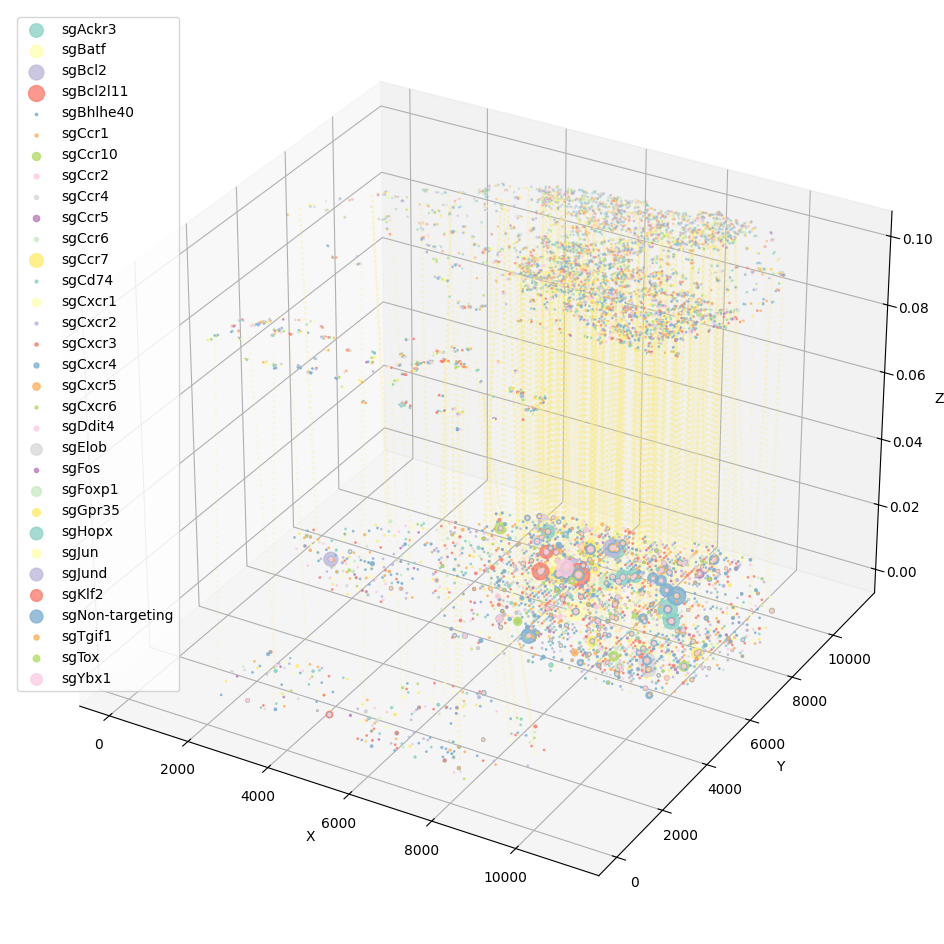

In [295]:
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import KDTree

# 创建颜色映射
unique_guides = guide_data.var_names.unique()
colors = sns.color_palette("Set3", len(unique_guides))
color_mapping = {guide: color for guide, color in zip(unique_guides, colors)}

# 3D 绘图
fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(111, projection='3d')

# 绘制 map_df 和 guide_data 在 3D 空间中
map_df = map_df[~(map_df['perturb_gene'] == 'Duplicate')]
ax.scatter(map_df['coord_x'], map_df['coord_y'], np.zeros_like(map_df['coord_x']) + 0.1, s=1, c=map_df['perturb_gene'].map(lambda x: color_mapping[x] if x not in ['sgTcf7'] else 'white'))
for guide in unique_guides:
    utils.plot_dot(guide_data, gene_name=guide, ax=ax, square=False, alpha=0.8, color=color_mapping[guide])

# 添加虚线连接 guide 相同的、最近的点
for guide in unique_guides:
    
    if guide not in ['sgCcr7']: continue
    map_df_guide = map_df[map_df['perturb_gene'] == guide]
    guide_data_guide = pd.DataFrame(guide_data[guide_data[:, guide].X > 0].obsm['spatial'], columns=['coord_x', 'coord_y'])

    # 使用 KDTree 找到最近的点
    tree = KDTree(guide_data_guide[['coord_x', 'coord_y']])
    distances, indices = tree.query(map_df_guide[['coord_x', 'coord_y']], k=1)
    
    for i, idx in enumerate(indices):
        x1, y1 = map_df_guide.iloc[i][['coord_x', 'coord_y']]
        x2, y2 = guide_data_guide.iloc[idx][['coord_x', 'coord_y']]
        ax.plot([x1, x2], [y1, y2], [0, 0.1], linestyle='dotted', color=color_mapping[guide], alpha=0.2)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show()

In [15]:
from libpysal.weights import DistanceBand
import esda
from tqdm import tqdm

d_dict = {}
for guide in tqdm(guide_data.var_names):
    cnt_df = pd.concat([pd.DataFrame(guide_data.obsm['spatial'], columns=['coord_x', 'coord_y']),
        pd.DataFrame(guide_data[:, guide].X.toarray().tolist(), columns=['guide_cnt'])], axis=1)
    map_df['guide_map'] = (map_df['perturb_gene'] == guide).map({False: 0, True: 1}).tolist()
    m_df = pd.concat([cnt_df, map_df])[['coord_x', 'coord_y', 'guide_cnt', 'guide_map']].fillna(0)
    dist_weights = DistanceBand(np.array(m_df.loc[:, ['coord_x', 'coord_y']]), binary=True, threshold=255)
    bi_moran = esda.moran.Moran_BV(m_df['guide_cnt'], m_df['guide_map'], dist_weights)
    d_dict[guide] = bi_moran.I

  0%|          | 0/32 [00:00<?, ?it/s]/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  W.__init__(
  3%|▎         | 1/32 [00:03<01:59,  3.85s/it]/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  W.__init__(
  6%|▋         | 2/32 [00:06<01:42,  3.42s/it]

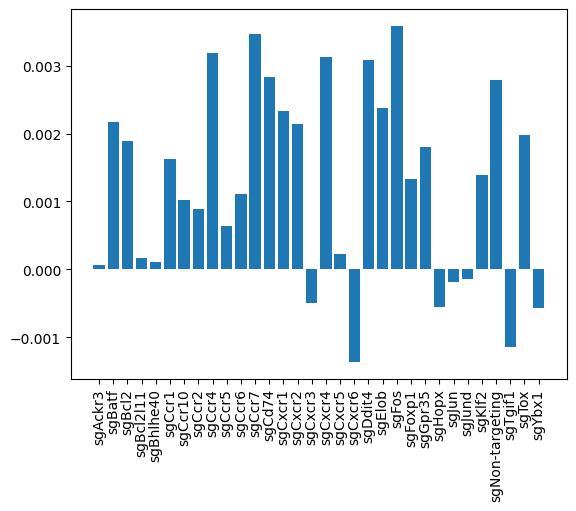

In [16]:
plt.bar(d_dict.keys(), d_dict.values())
plt.xticks(rotation=90)
plt.show()

In [17]:
map_df['coord_x'] = np.floor(map_df['coord_x']).tolist()
map_df['coord_y'] = np.floor(map_df['coord_y']).tolist()

In [20]:
map_df['coord_x_bin100'] = (map_df['coord_x'] + 50) // 100 * 100
map_df['coord_y_bin100'] = (map_df['coord_y'] + 50) // 100 * 100
map_df

coord_x  coord_y          perturb     perturb_gene  \
CCATTCGCATCGATTG.1     1410.0   8090.0        Duplicate          sgCxcr4   
TTGGAACGTAGCGTAG.1     1478.0   8199.0        Duplicate           sgBcl2   
CTCACACTCAGCGACC.1     1401.0   8201.0        Duplicate           sgCcr1   
GTATTCTTCTCGGACG.1     1450.0   8090.0           Bcl2-1           sgBcl2   
ACTATCTTCAAGGCTT.1     1378.0   8134.0  Non-targeting_6  sgNon-targeting   
...                       ...      ...              ...              ...   
ATCTGCCCAAGCTGAG.1.1   7389.0   6450.0          Cxcr6-1          sgCxcr6   
ATTATCCAGTGACATA.1    10126.0   8298.0        Duplicate           sgCcr1   
ACGGGTCAGCCTATGT.1     2407.0   8593.0        Duplicate          sgCxcr4   
AGCAGCCGTATTACCG.1.3   8301.0   4896.0          Cxcr1-2          sgCxcr1   
GACACGCAGTAGGTGC.1.2   3797.0   7144.0        Duplicate           sgCcr7   

                      guide_map  coord_x_bin100  coord_y_bin100  
CCATTCGCATCGATTG.1            0          1400.0          8100.0  
TTGGAACGTAGCGTAG.1            0          1500.0          8200.0  
CTCACACTCAGCGACC.1            0          1400.0          8200.0  
GTATTCTTCTCGGACG.1            0          1500.0          8100.0  
ACTATCTTCAAGGCTT.1            0          1400.0          8100.0  
...                         ...             ...             ...  
ATCTGCCCAAGCTGAG.1.1          0          7400.0          6500.0  
ATTATCCAGTGACATA.1            0         10100.0          8300.0  
ACGGGTCAGCCTATGT.1            0          2400.0          8600.0  
AGCAGCCGTATTACCG.1.3          0          8300.0          4900.0  
GACACGCAGTAGGTGC.1.2          0          3800.0          7100.0  

[7409 rows x 7 columns]

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


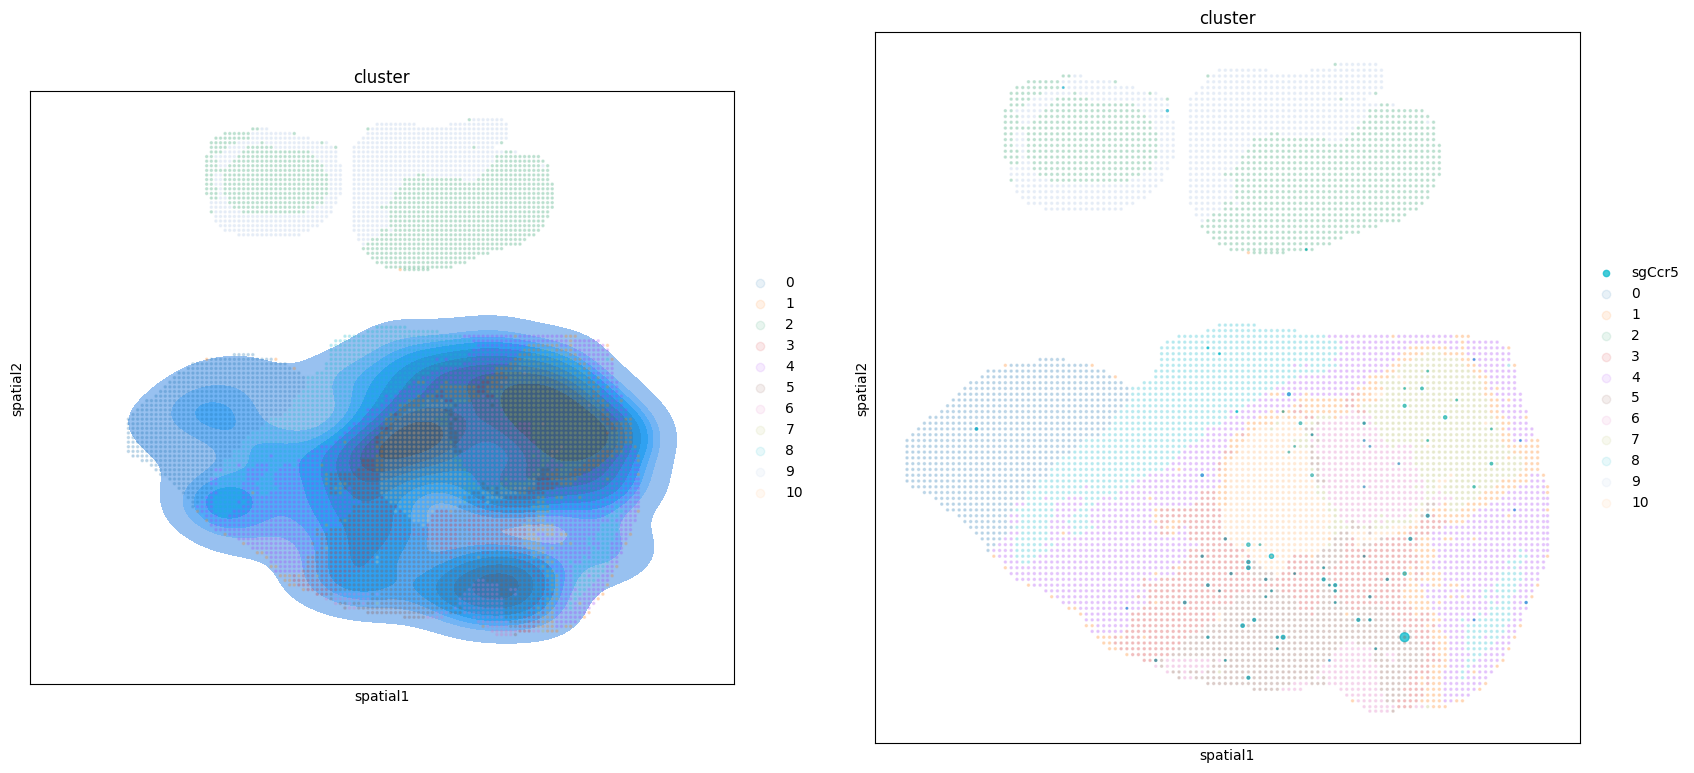

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(20, 12))
sns.kdeplot(map_df[map_df.perturb_gene == 'sgCcr5'], x='coord_x_bin100', y='coord_y_bin100', hue='perturb_gene', bw_adjust=0.7, fill=True, legend=True, ax=ax[0])
# sns.scatterplot(spatial_df, x='coord_x', y='coord_y', hue='guide', size=0.001, legend=True, ax=ax[1])
colors = sns.color_palette("tab10", len(guide_data.var_names.unique()))
color_mapping = {guide: color for guide, color in zip(guide_data.var_names.unique(), colors)}
for guide in guide_data.var_names.unique():
    if guide not in ['sgCcr5']: continue
    utils.plot_dot(guide_data, gene_name=guide, ax=ax[1], square=False, alpha=0.8, color=color_mapping[guide])
sq.pl.spatial_scatter(cluster_data, color='cluster', shape=None, size=10, library_id='spatial', alpha=0.1, ax=ax[0])
sq.pl.spatial_scatter(cluster_data, color='cluster', shape=None, size=10, library_id='spatial', alpha=0.1, ax=ax[1])
plt.show()

In [ ]:
guide_data.obs['shannon_index'] = 

In [278]:
cluster_data, guide_data = utils.align_rna_guide_data(cluster_data, guide_data)

/home/wpy/stereoseq/20240702-Exclusive/bin/utils.py:126: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  rnadata.obs["cov"] = [str(marker) + '_' + str(array[0]) + "-" + str(array[1]) for marker, array in zip(rnadata.obs[marker_name], rnadata.obsm["spatial"])]


/tmp/ipykernel_38186/909816000.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cnt_df = pd.concat([pd.DataFrame(guide_data.X, columns=guide_data.var_names, index=guide_data.obs_names), cluster_data.obs.cluster], axis=1).groupby('cluster').sum()


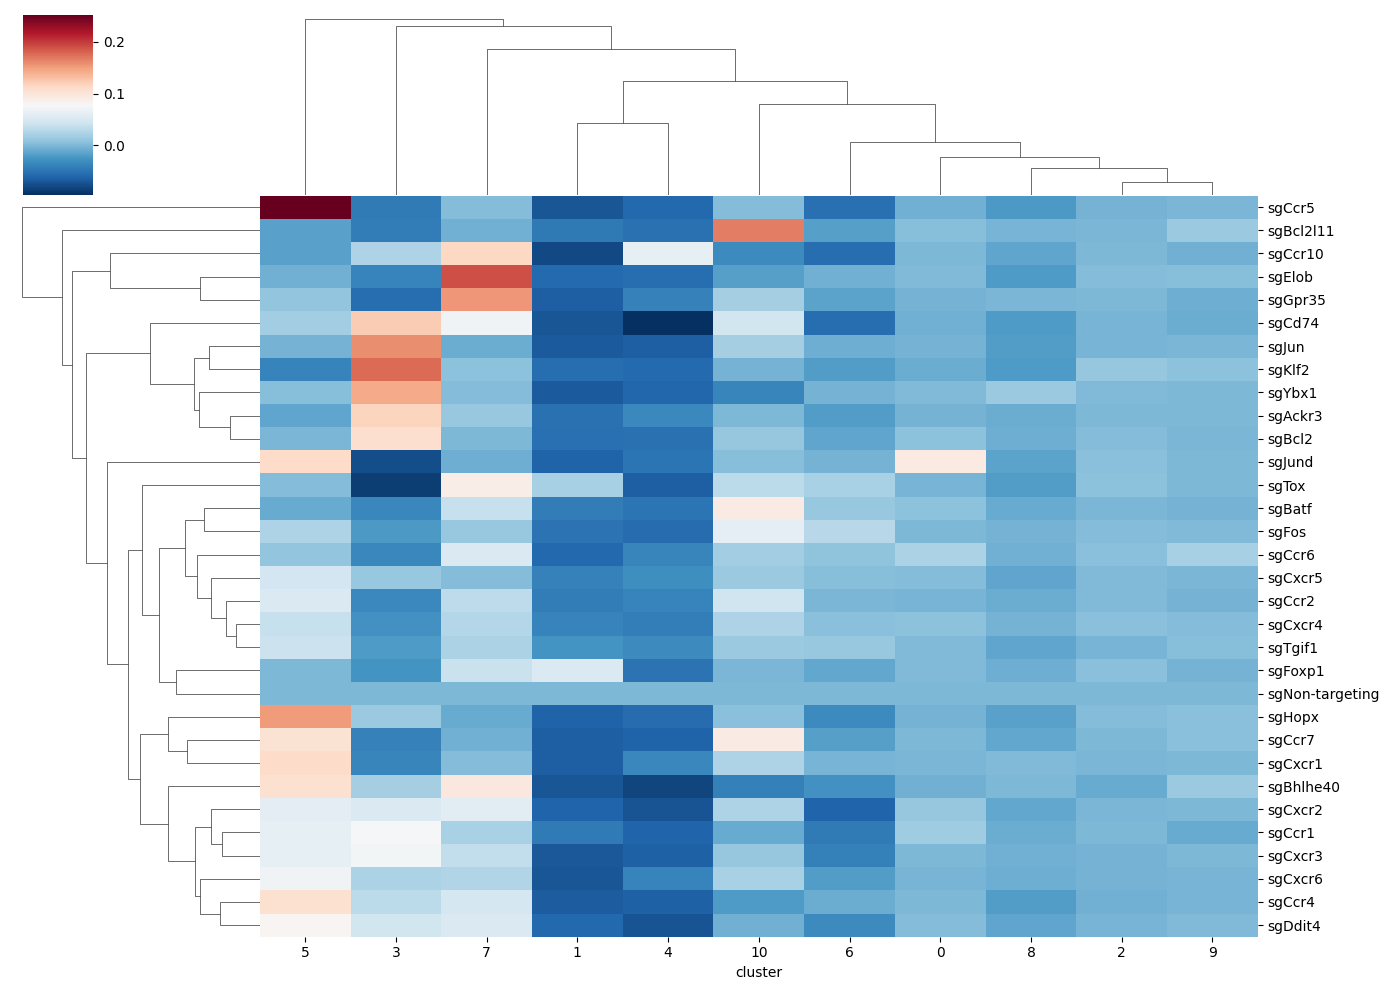

In [304]:
cnt_df = pd.concat([pd.DataFrame(guide_data.X, columns=guide_data.var_names, index=guide_data.obs_names), cluster_data.obs.cluster], axis=1).groupby('cluster').sum()
cnt_df = cnt_df.div(cnt_df.sum(axis=0)).T
cnt_df = cnt_df - cnt_df.loc['sgNon-targeting', :]

import seaborn as sns
sns.clustermap(cnt_df, cmap='RdBu_r', figsize=(14, 10))

In [299]:
a_df = cluster_data[cluster_data.obs['marker'] == 'A'].obs.copy()
a_df['coord_x'] = cluster_data[cluster_data.obs['marker'] == 'A'].obsm['spatial'][:, 0] // 100 * 100
a_df['coord_y'] = cluster_data[cluster_data.obs['marker'] == 'A'].obsm['spatial'][:, 1] // 100 * 100
a_dict = a_df.loc[:, ['coord_x', 'coord_y', 'cluster']].set_index(['coord_x', 'coord_y']).to_dict()['cluster']
a_vec = [tuple(array // 100 * 100) for array in np.array(map_df[['coord_x', 'coord_y']].map(lambda x: int(x)))]
map_df['cluster'] = [a_dict[x] if x in a_dict else None for x in a_vec]

/tmp/ipykernel_38186/4095278204.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  map_df['cluster'] = [a_dict[x] if x in a_dict else None for x in a_vec]


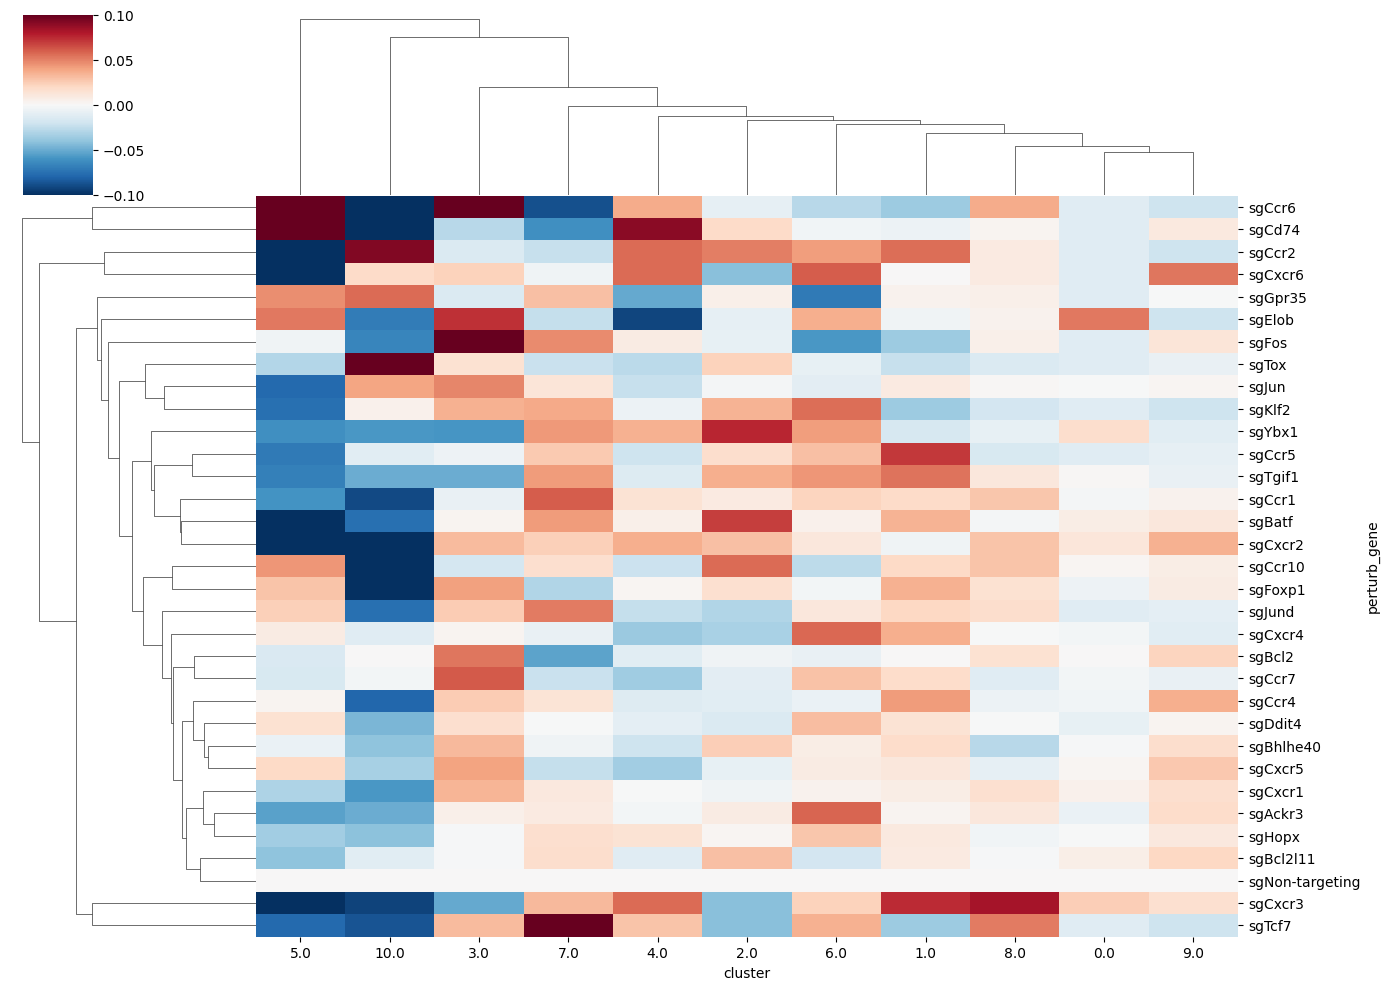

In [302]:
p_df = map_df.groupby('cluster')['perturb_gene'].value_counts().unstack().fillna(0)
p_df = p_df.div(p_df.sum(axis=0)).T
p_df = p_df - p_df.loc['sgNon-targeting', :]
sns.clustermap(p_df, cmap='RdBu_r', figsize=(14, 10), vmax=0.1, vmin=-0.1)

In [305]:
from scipy.stats import spearmanr
r_dict = {}
for guide in guide_data.var_names:
    r_dict[guide] = spearmanr(cnt_df.loc[guide, :], p_df.loc[guide, :])[0]

/tmp/ipykernel_38186/3562432614.py:4: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_dict[guide] = spearmanr(cnt_df.loc[guide, :], p_df.loc[guide, :])[0]


Text(0.5, 1.0, 'Spearman correlation of cluster proportion with SC referred and Real detected guide')

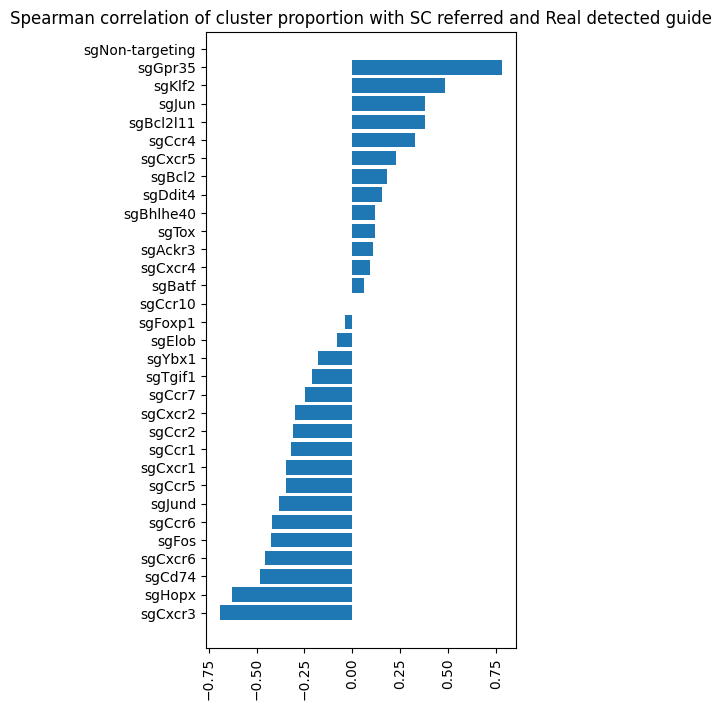

In [306]:
plot_df = pd.DataFrame(r_dict, index=['r']).T
plot_df.sort_values(by='r', inplace=True)
plt.figure(figsize=(4, 8))
plt.barh(plot_df.index, plot_df.r)
plt.xticks(rotation=90)
plt.title('Spearman correlation of cluster proportion with SC referred and Real detected guide')

In [155]:
cells = np.unique([array + '-1' for array in map_df.index.str.split('.').str.get(0)])

In [318]:
sc_data = sc.read_h5ad('./RNA/sc.combined.dedup.clustered.h5')

In [185]:
spatial_data.var_names

Index(['0610005C13Rik', '0610006L08Rik', '0610009B22Rik', '0610009O20Rik',
       '0610010F05Rik', '0610010K14Rik', '0610012D04Rik', '0610012G03Rik',
       '0610030E20Rik', '0610037L13Rik',
       ...
       'sgNon-targeting_3', 'sgNon-targeting_4', 'sgNon-targeting_5',
       'sgNon-targeting_6', 'sgTgif1_1', 'sgTgif1_2', 'sgTox_1', 'sgTox_2',
       'sgYbx1_1', 'sgYbx1_2'],
      dtype='object', length=20921)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


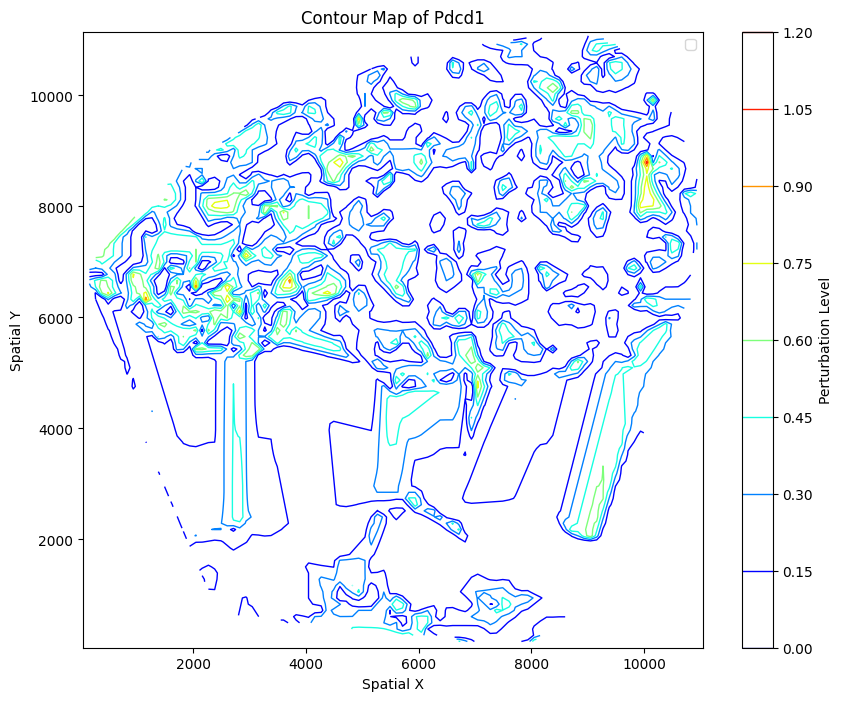

In [210]:
#fig, ax = plt.subplots(1, 1, figsize=(10, 10))

plot_data = spatial_data[spatial_data.obs.marker == 'A'].copy()
spatial_coords = plot_data.obsm['spatial']
gene_expression = plot_data[:, "Foxo1"].X.toarray().flatten().tolist()

# Create a DataFrame with spatial coordinates and gene expression
df = pd.DataFrame(spatial_coords, columns=['x', 'y'])
df['expression'] = gene_expression

# Filter out points with zero or near-zero expression values
threshold = 0.01  # You can adjust this threshold based on your data
df_filtered = df[df['expression'] > threshold]

# Create a grid of points for contour plotting
x = df_filtered['x']
y = df_filtered['y']
z = df_filtered['expression']
vmax = 25
z_ = np.array([vmax if z_ > vmax else z_ for z_ in z])
z = np.log10(z_ + 1e-9)

# Create grid values first.
xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
xi, yi = np.meshgrid(xi, yi)

# Interpolate over grid
from scipy.interpolate import griddata
import matplotlib.cm as cm
zi = griddata((x, y), z, (xi, yi), method='linear')

# Plot contour map
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
contour = plt.contour(xi, yi, zi, levels=10, linewidths=1, cmap="jet")
plt.legend()

plt.title(f'Contour Map of Pdcd1')
plt.xlabel('Spatial X')
plt.ylabel('Spatial Y')
plt.colorbar(label='Perturbation Level')
plt.show()

In [319]:
map_df['umi'] = [array + '-1' for array in map_df.index.str.split('.').str.get(0)]
map_dict = sc_data[np.isin(sc_data.obs_names, cells)].obs[['leiden']].to_dict()['leiden']
map_df['type'] = map_df['umi'].map(map_dict)
map_df.dropna(inplace=True)

<Axes: xlabel='coord_x', ylabel='coord_y'>

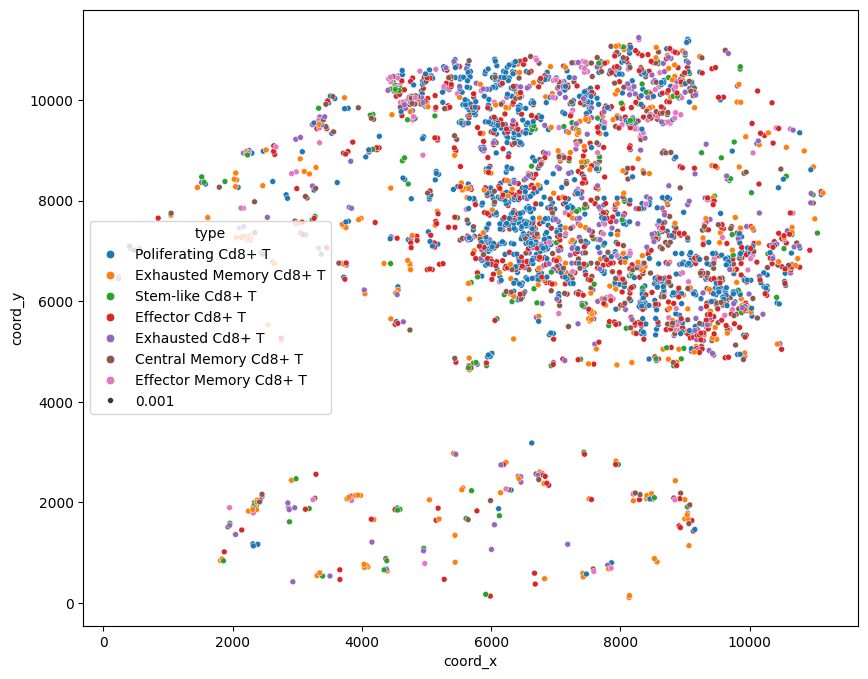

In [320]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.scatterplot(map_df, x='coord_x', y='coord_y', hue='type', size=0.001, ax=ax)

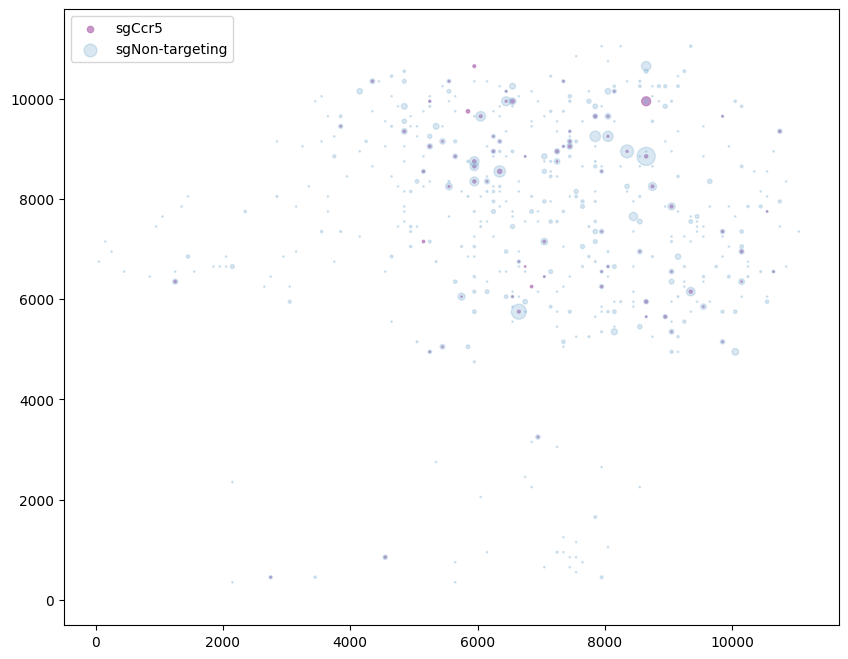

In [265]:
# 创建颜色映射
unique_guides = guide_data.var_names.unique()
colors = sns.color_palette("Set3", len(unique_guides))
color_mapping = {guide: color for guide, color in zip(unique_guides, colors)}

# 3D 绘图
fig, ax = plt.subplots(figsize=(10, 8))

for guide in unique_guides:
    if guide != 'sgCcr5' and guide != 'sgNon-targeting': continue
    if guide == 'sgNon-targeting': alpha = 0.3
    else: alpha = 0.8
    utils.plot_dot(guide_data, gene_name=guide, ax=ax, square=False, alpha=alpha, color=color_mapping[guide])
plt.legend()

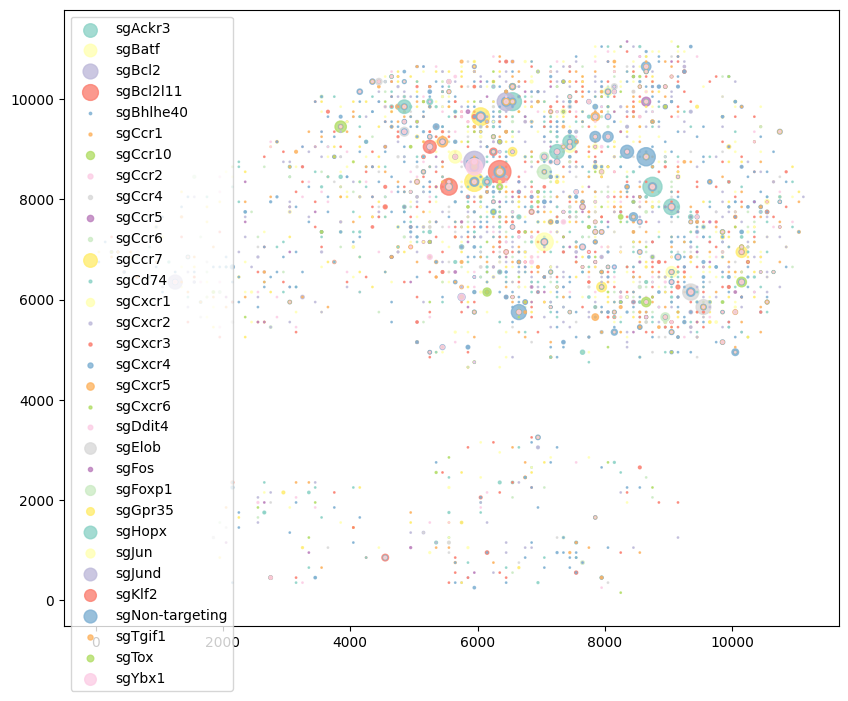

In [256]:
# 创建颜色映射
unique_guides = guide_data.var_names.unique()
colors = sns.color_palette("Set3", len(unique_guides))
color_mapping = {guide: color for guide, color in zip(unique_guides, colors)}

# 3D 绘图
fig, ax = plt.subplots(figsize=(10, 8))

for guide in unique_guides:
    utils.plot_dot(guide_data, gene_name=guide, ax=ax, square=False, alpha=0.8, color=color_mapping[guide])
plt.legend()

In [215]:
Cytotoxicity_sig=["Prf1", "Gzma", "Gzmb", 'Gzmb', "Ifng"]
Proliferation_sig=['Cdk1', 'Mki67', 'Stmn1','Top2a']
Exhaustion_sig=["Havcr2", "Lag3", "Entpd1", "Tigit", "Ctla4", "Layn", "Pdcd1"]
Memory_sig=["Il7r", "Cd27", "Selp", "Ccr7", "Lef1"]
Regulation_sig=["Foxp3", "Ctla4", "Il2ra"]
StemLike_sig=["Tcf7", "Id3"]

In [216]:
spatial_data.obs['Proliferation sig.']=np.mean(spatial_data.to_df().loc[: ,Proliferation_sig],axis=1)
spatial_data.obs['Cytotoxicity sig.']=np.mean(spatial_data.to_df().loc[: ,Cytotoxicity_sig],axis=1)
spatial_data.obs['Exhaustion sig.']=np.mean(spatial_data.to_df().loc[: ,Exhaustion_sig],axis=1)
spatial_data.obs['Memory sig.']=np.mean(spatial_data.to_df().loc[: ,Memory_sig],axis=1)
spatial_data.obs['Regulation sig.']=np.mean(spatial_data.to_df().loc[: ,Regulation_sig],axis=1)
spatial_data.obs['StemLike sig.']=np.mean(spatial_data.to_df().loc[: ,StemLike_sig],axis=1)

In [220]:
spatial_data

AnnData object with n_obs × n_vars = 11622 × 20921
    obs: 'marker', 'score', 'Proliferation sig.', 'Cytotoxicity sig.', 'Exhaustion sig.', 'Memory sig.', 'Regulation sig.', 'StemLike sig.'
    obsm: 'spatial'

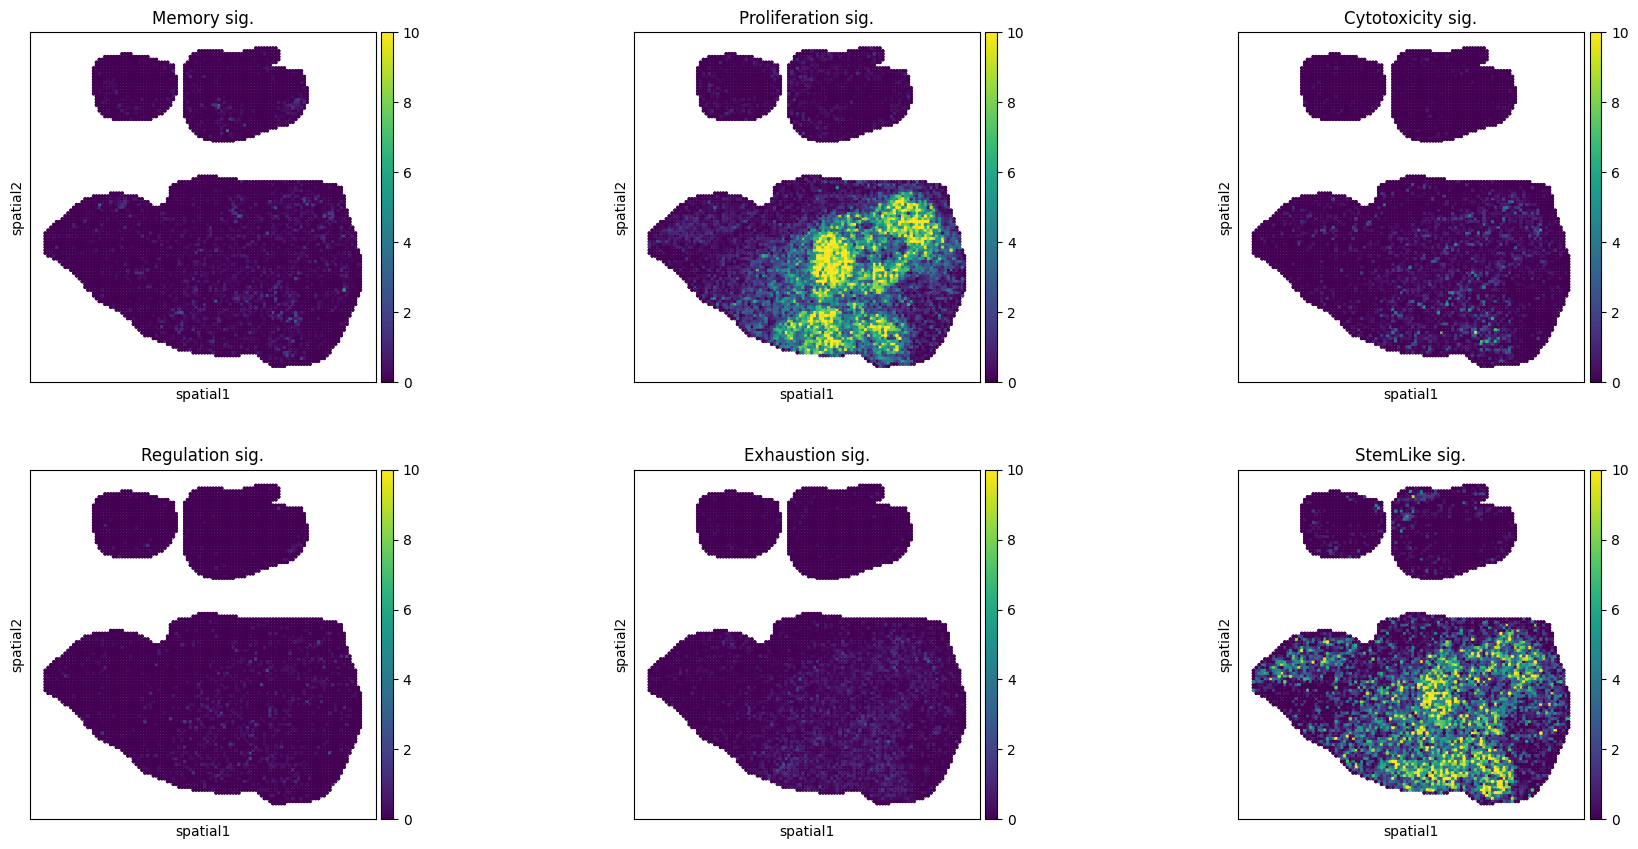

In [232]:
sq.pl.spatial_scatter(spatial_data[spatial_data.obs.marker == 'A'],color=['Memory sig.','Proliferation sig.','Cytotoxicity sig.','Regulation sig.','Exhaustion sig.','StemLike sig.'],
    shape=None, size=10, library_id='spatial', ncols=3, vmax='10')

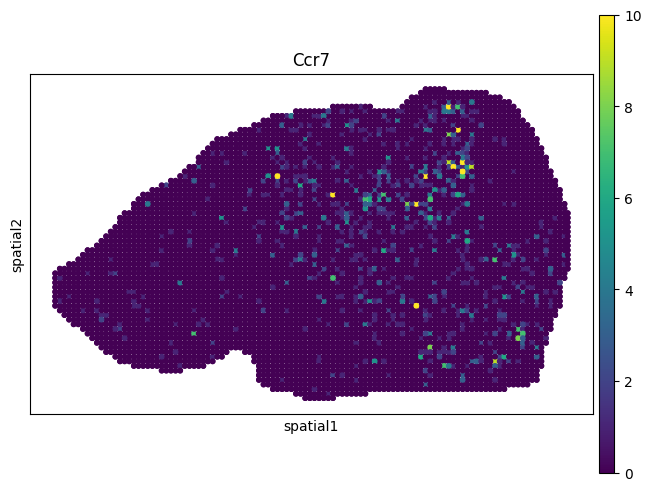

In [255]:
sq.pl.spatial_scatter(spatial_data[(spatial_data.obsm['spatial'][:, 1] > 4000) & (spatial_data.obs['marker'] == 'A')].copy(),
    color='Ccr7', size=40, shape=None, library_id='spatial', vmax=10)
plt.gca().invert_yaxis()